In [180]:
%matplotlib inline

import os
import time 

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.onnx

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Load dataset - QMNIST: Enhanced MNIST with more accurate labels and additional data.

In [181]:
train_batch_size = 4
test_batch_size = 4

epochs = 1000

In [182]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

trainset = datasets.QMNIST(
          root = './data',
          train = True,
          download = True,
          transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = train_batch_size,
                                           shuffle = True, num_workers = 8)

testset =  datasets.QMNIST(
          root = './data',
          train = False,
          download = True,
          transform = transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = test_batch_size,
                                           shuffle = False, num_workers = 8)

classes = ('0','1','2','3','4','5','6','7','8','9')

#check image size
image, _ = trainset[0]
image_size = image.size()
print("Image size for training set:", image_size, image.dtype)

Image size for training set: torch.Size([1, 28, 28]) torch.float32


Show some of the training images

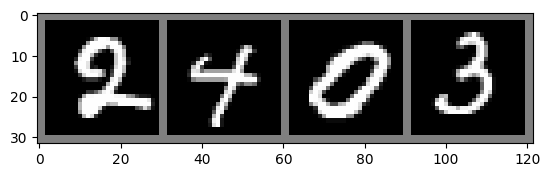

    2     4     0     3


In [183]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(train_batch_size)))

Create neural network

In [184]:
class Net(nn.Module):
    def __init__(self, name=None):
        super(Net, self).__init__()
        if name:
            self.name = name
        #num channels input, num channels output, filter size 
        #num channels output: i.e. num feature maps produced thus will require 6 filters
        self.conv1 = nn.Conv2d(1, 10, 5)
        #filtersize,stride.
        #maxpool acts the same way in each channel, so doesn't need to be fed the num channels of the input
        self.pool = nn.MaxPool2d(kernel_size=(3, 2), stride=2)
        self.conv2 = nn.Conv2d(10, 16, 5)
        #since conv2 changes to 768
        self.fc1 = nn.Linear(16 * 3 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)

    def forward(self, x):
        #print("Input shape:", x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print("After conv1 and pooling shape:", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print("After conv2 and pooling shape:", x.shape)
        #the calculation of window sizes is
        #convo1 outputs=24x24;pool1 outputs=11.5*12;convo2 outputs=7.5*8;pool2 outputs=3.25*3
        #hence x.view is 16*4*3 to round
        #-1 takes the batch size
        x = x.view(-1, 16 * 4 * 3)
        #print("After flattening shape:", x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net(name='Q-MNIST')
net.to(device)
print(net)

Q-MNIST: total params: 38450
Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(3, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Set loss function and optimizer

In [185]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Training

In [186]:
start = time.time()

print("expect max",len(trainloader),"per epoch")

for epoch in range(epochs):  # loop over the dataset multiple times
    
    print("start epoch",epoch)
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        #print("at epoch",epoch,"at i",i,"data",data)

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        if loss is not None:

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

            if loss.item() < 0.00000001:
                print(f"Loss is less than 0.000001:{loss.item()} Stopping training.")
                break

    else:
        #print("at continue")
        continue
    #print("outter loop break")
    break

print('Finished Training')

end = time.time()
print('training time ', end-start)

expect max 15000 per epoch
start epoch 0
[1,  2000] loss: 1.042
[1,  4000] loss: 0.205
[1,  6000] loss: 0.143
[1,  8000] loss: 0.116
[1, 10000] loss: 0.100
[1, 12000] loss: 0.094
[1, 14000] loss: 0.082
start epoch 1
[2,  2000] loss: 0.072
[2,  4000] loss: 0.065
[2,  6000] loss: 0.068
[2,  8000] loss: 0.068
[2, 10000] loss: 0.049
[2, 12000] loss: 0.049
[2, 14000] loss: 0.049
start epoch 2
[3,  2000] loss: 0.040
[3,  4000] loss: 0.044
[3,  6000] loss: 0.041
[3,  8000] loss: 0.043
[3, 10000] loss: 0.045
[3, 12000] loss: 0.042
[3, 14000] loss: 0.043
start epoch 3
[4,  2000] loss: 0.032
[4,  4000] loss: 0.032
[4,  6000] loss: 0.033
[4,  8000] loss: 0.036
[4, 10000] loss: 0.037
[4, 12000] loss: 0.032
[4, 14000] loss: 0.038
start epoch 4
[5,  2000] loss: 0.031
[5,  4000] loss: 0.029
[5,  6000] loss: 0.028
Loss is less than 0.000001:0.0 Stopping training.
Finished Training
training time  129.7008032798767


Testing

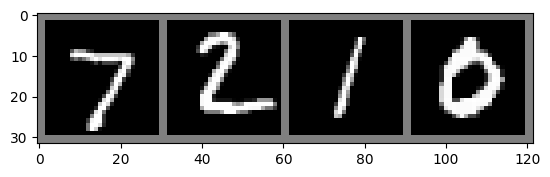

GroundTruth:      7     2     1     0


In [187]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(test_batch_size)))

images, labels = images.to(device), labels.to(device)

Get prediction from network



In [188]:
outputs = net(images)

In [189]:
_, predicted = torch.max(outputs, 1)
print("size output",outputs.size())

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(test_batch_size)))

size output torch.Size([4, 10])
Predicted:      7     2     1     0


Testing - Full testing dataset

In [190]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        #images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


Naive approach prediction probability 10% (1/10 digits)

In [191]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        #images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        c = (predicted == labels)

        #print("c",c,"size",c.size(),"enumel",c.numel())

        #address c not scalar
        if c.numel() > 1:
            c = c.squeeze()
        else:
            #convert to single ele
            c = torch.tensor([c.item()])
            print("type c",c.dtype)
            
        for i in range(test_batch_size):
            label = labels[i]
            #if test_batch_size-1 > 1:
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("class_correct",class_correct)
print("class_total", class_total)
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

class_correct [5888.0, 6748.0, 5971.0, 5995.0, 5753.0, 5425.0, 5801.0, 6108.0, 5741.0, 5755.0]
class_total [5952.0, 6791.0, 6026.0, 6084.0, 5780.0, 5454.0, 5957.0, 6231.0, 5890.0, 5835.0]
Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 98 %
Accuracy of     4 : 99 %
Accuracy of     5 : 99 %
Accuracy of     6 : 97 %
Accuracy of     7 : 98 %
Accuracy of     8 : 97 %
Accuracy of     9 : 98 %


Convert model to onnx

In [192]:
image, _ = trainset[0]
image_size = image.size()
print("Image size for training set:", image_size)

#save weights
weights_path = 'qminst_weights.pth'
torch.save(net.state_dict(), weights_path)

#Load weights
#w_path = os.path.join(os.getcwd(), 'qminst_weights.pth')
#net.load_state_dict(torch.load(w_path))

#set model to eval mode
net.eval()

#dummy input tensor match model input shape
dummy_input = torch.randn(1, 1, 28, 28, dtype=torch.float32) 

#model to cpu
net.cpu()
model_path = os.path.join(os.getcwd(), 'qminst_model.onnx')
torch.onnx.export(net, dummy_input, model_path,
                  verbose=True, 
                  input_names=['input'], 
                  output_names=['output'], 
                  opset_version=15)

Image size for training set: torch.Size([1, 28, 28])
